# A two-sector I-HANK model

**Table of contents**<a id='toc0_'></a>    
- 1. [Setup](#toc1_)    
- 2. [Steady state](#toc2_)    
- 3. [Compute Jacobians](#toc3_)    
- 4. [Foreign demand shock](#toc4_)    
- 5. [Response in consumption to different shocks](#toc5_)    
- 6. [Decomposing consumption response](#toc6_)    
- 7. [Fixed vs floating exchange rate](#toc7_)    
- 8. [Decomposing consumption response under fixed exchange rate](#toc8_)    

<!-- vscode-jupyter-toc-config
	numbering=true
	anchor=true
	flat=false
	minLevel=2
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np

import matplotlib.pyplot as plt   
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
plt.rcParams.update({"axes.grid" : True, "grid.color": "black", "grid.alpha":"0.25", "grid.linestyle": "--"})
plt.rcParams.update({'font.size': 14})

from IHANKModel import IHANKModelClass

## 1. <a id='toc1_'></a>[Setup](#toc0_)

In [2]:
model = IHANKModelClass(name='baseline')

In [3]:
model.info()

settings:
 par.py_hh = False
 par.py_blocks = False
 par.full_z_trans = False
 par.warnings = True
 par.T = 500

households:
 grids_hh: [a]
 pols_hh: [a]
 inputs_hh: [beta,ra,inc_TH,inc_NT]
 inputs_hh_z: []
 outputs_hh: [a,c,uc_TH,uc_NT,c_TH,c_NT]
 intertemps_hh: [vbeg_a]

aggregate:
 shocks: [ZTH,ZNT,M_s,rF,PF_s,beta,G,i_shock]
 unknowns: [CB,NNT,NTH,piWTH,piWNT]
 targets: [NKWCT_res,NKWCNT_res,clearing_YTH,clearing_YNT,UIP_res]

blocks (inputs -> outputs):
 mon_pol: [CB] -> [E]
 production: [ZTH,ZNT,NTH,NNT,piWTH,piWNT] -> [YTH,YNT,WTH,WNT,PTH,PNT]
 prices: [PF_s,E,PTH,PNT,WTH,WNT] -> [PF,PTH_s,PT,P,Q,wTH,wNT]
 inflation: [PF_s,PF,PNT,PTH,PT,P,PTH_s] -> [pi_F_s,pi_F,pi_NT,pi_TH,pi_T,pi,pi_TH_s]
 central_bank: [pi,E,i_shock,CB] -> [i,r,ra]
 government: [PNT,P,wTH,NTH,wNT,NNT,ra,G] -> [B,tau,inc_TH,inc_NT]
 hh: [beta,inc_NT,inc_TH,ra] -> [A_hh,C_hh,UC_TH_hh,UC_NT_hh,C_TH_hh,C_NT_hh]
 NKWCs: [beta,piWTH,piWNT,NTH,NNT,wTH,wNT,tau,UC_TH_hh,UC_NT_hh] -> [NKWCT_res,NKWCNT_res]
 UIP: [Q,r,rF

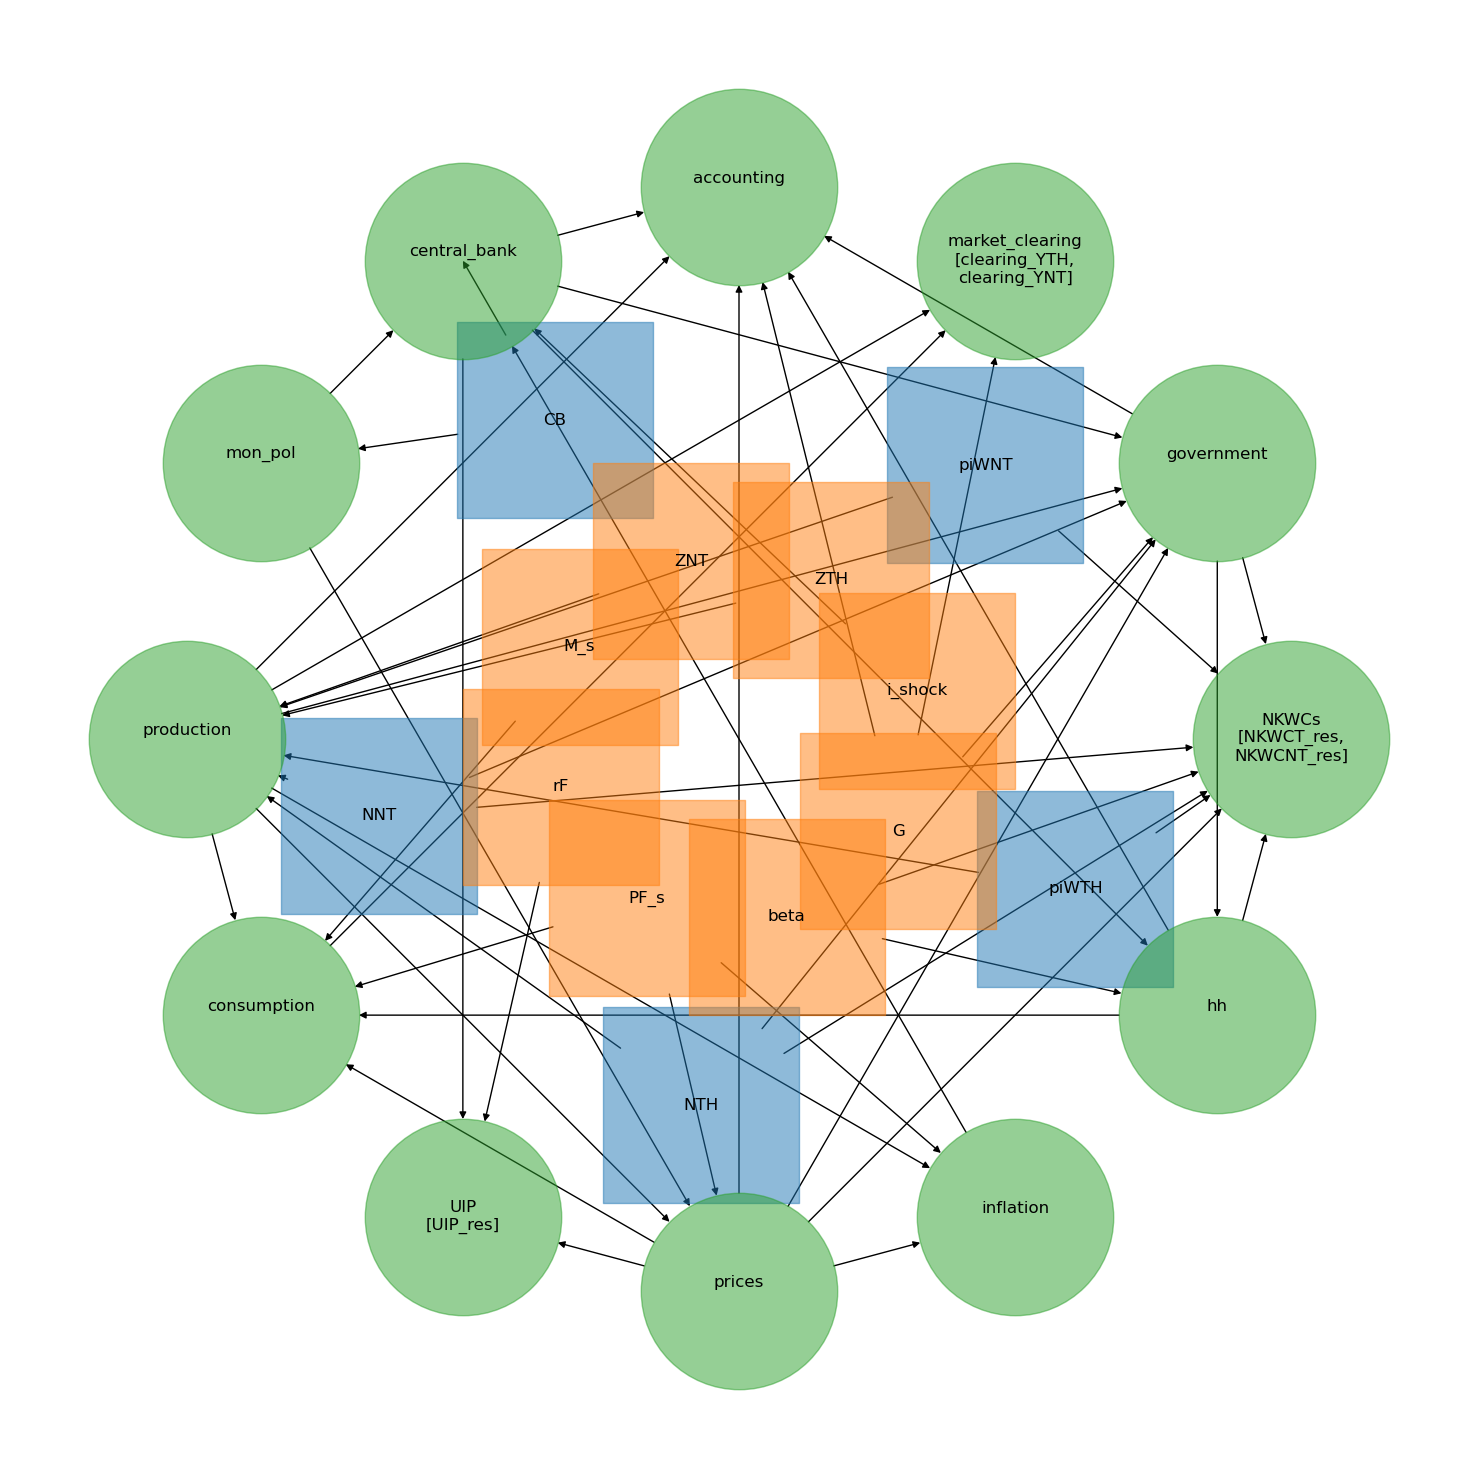

In [4]:
model.draw_DAG(figsize=(15,15),order=['shocks','unknowns','blocks'])

In [5]:
par = model.par
ss = model.ss
path = model.path
sim = model.sim

## 2. <a id='toc2_'></a>[Steady state](#toc0_)

In [6]:
model.find_ss(do_print=True)

household problem in ss solved in 4.5 secs [375 iterations]
household problem in ss simulated in 4.5 secs [419 iterations]
steady state found in 9.8 secs
ss.inc_TH = 0.175
ss.inc_NT = 0.525
par.alphaT = 0.355
par.alphaF = 0.333
par.varphiTH = 1.271
par.varphiNT = 1.271
ss.M_s = 0.083
ss.clearing_YTH =   0.00000000
ss.clearing_YNT =   0.00000000
ss.G = 0.296
ss.NFA = 0.000


In [7]:
model.test_ss()

E              :       1.0000
CB             :       1.0000
ZTH            :       1.0000
ZNT            :       1.0000
NTH            :       0.2500
NNT            :       0.7500
piWTH          :       0.0000
piWNT          :       0.0000
YTH            :       0.2500
YNT            :       0.7500
WTH            :       1.0000
WNT            :       1.0000
PTH            :       1.0000
PNT            :       1.0000
PF_s           :       1.0000
PF             :       1.0000
PTH_s          :       1.0000
PT             :       1.0000
P              :       1.0000
Q              :       1.0000
wTH            :       1.0000
wNT            :       1.0000
pi_F_s         :       0.0000
pi_F           :       0.0000
pi_NT          :       0.0000
pi_TH          :       0.0000
pi_T           :       0.0000
pi             :       0.0000
pi_TH_s        :       0.0000
i              :       0.0050
r              :       0.0050
ra             :       0.0050
i_shock        :       0.0000
G         

In [8]:
MPC = np.sum(ss.D[:,:,:-1]*(ss.c[:,:,1:]-ss.c[:,:,:-1])/((1+ss.r)*(par.a_grid[1:]-par.a_grid[:-1])))
print(f'{MPC:.2f}')

0.32


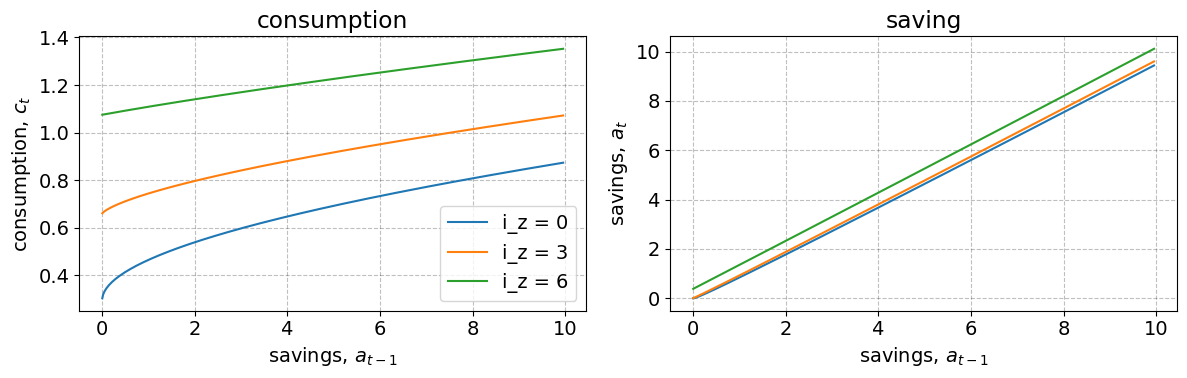

In [9]:
fig = plt.figure(figsize=(18,4),dpi=100)
a_max = 10

# a. consumption
I = par.a_grid < a_max

ax = fig.add_subplot(1,3,1)
ax.set_title(f'consumption')

for i_z in [0,par.Nz//2,par.Nz-1]:
    ax.plot(par.a_grid[I],ss.c[0,i_z,I],label=f'i_z = {i_z}')

ax.legend(frameon=True)
ax.set_xlabel('savings, $a_{t-1}$')
ax.set_ylabel('consumption, $c_t$')

# b. saving
I = par.a_grid < a_max

ax = fig.add_subplot(1,3,2)
ax.set_title(f'saving')

for i_z in [0,par.Nz//2,par.Nz-1]:
    ax.plot(par.a_grid[I],ss.a[0,i_z,I],label=f'i_z = {i_z}')

ax.set_xlabel('savings, $a_{t-1}$')
ax.set_ylabel('savings, $a_{t}$')

fig.tight_layout()

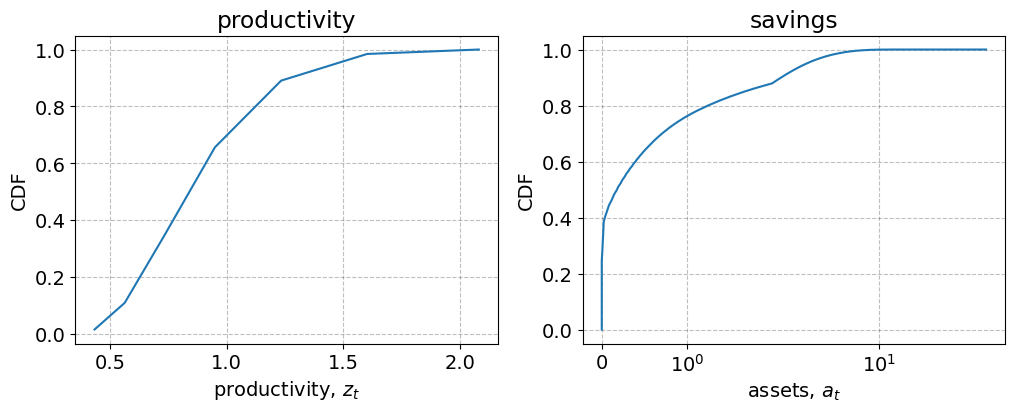

In [10]:
fig = plt.figure(figsize=(12,4),dpi=100)

# a. income
ax = fig.add_subplot(1,2,1)
ax.set_title('productivity')

y = np.cumsum(np.sum(ss.D[0],axis=1))
ax.plot(par.z_grid,y/y[-1])

ax.set_xlabel('productivity, $z_{t}$')
ax.set_ylabel('CDF')

# b. assets
ax = fig.add_subplot(1,2,2)
ax.set_title('savings')
y = np.insert(np.cumsum(np.sum(ss.D[0],axis=0)),0,0.0)
ax.plot(np.insert(par.a_grid,0,par.a_grid[0]),y/y[-1])
        
ax.set_xlabel('assets, $a_{t}$')
ax.set_ylabel('CDF')
ax.set_xscale('symlog')

## 3. <a id='toc3_'></a>[Compute Jacobians](#toc0_)

**Household transition path:**

note: inputs = steady state value -> expected: constant value (straigt line) in roughly -10^-5 to 10^5

household problem solved along transition path in 1.0 secs
household problem simulated along transition in 2.7 secs



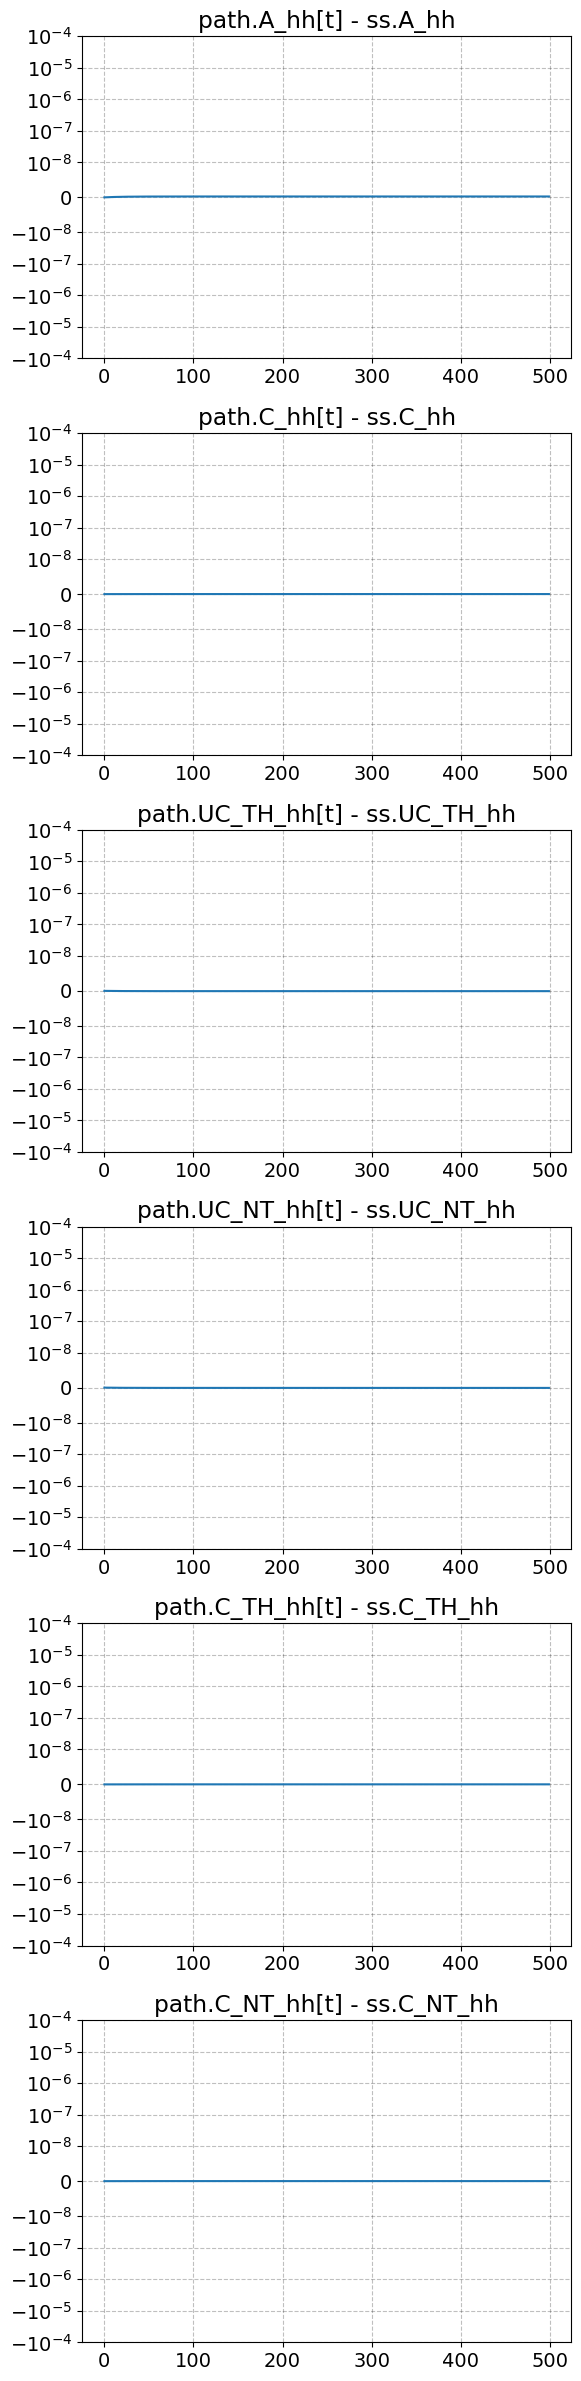

In [11]:
model.test_hh_path()

**Full transition path:**

In [12]:
model.test_path()

shocks: ZTH ZNT M_s rF PF_s beta G i_shock 
unknowns: CB NNT NTH piWTH piWNT 

look at max(abs(path.VARNAME[:]-ss.VARNAME)):

 blocks.mon_pol
  E                0.0e+00
 blocks.production
  YTH              0.0e+00
  YNT              0.0e+00
  WTH              0.0e+00
  WNT              0.0e+00
  PTH              0.0e+00
  PNT              0.0e+00
 blocks.prices
  PF               0.0e+00
  PTH_s            0.0e+00
  PT               0.0e+00
  P                0.0e+00
  Q                0.0e+00
  wTH              0.0e+00
  wNT              0.0e+00
 blocks.inflation
  pi_F_s           0.0e+00
  pi_F             0.0e+00
  pi_NT            0.0e+00
  pi_TH            0.0e+00
  pi_T             0.0e+00
  pi               0.0e+00
  pi_TH_s          0.0e+00
 blocks.central_bank
  i                1.1e-16
  r                1.1e-16
  ra               1.1e-16
 blocks.government
  B                5.6e-16
  tau              5.6e-17
  inc_TH           2.8e-17
  inc_NT           1.1e-16
 hh
  A_hh

**Jacobians:**

In [13]:
model.compute_jacs(do_print=True)

household Jacobians:
one step deviation from steady state calculated in 0.0 secs
curly_Y and curly_D calculated for beta            in 1.1 secs
curly_Y and curly_D calculated for inc_NT          in 1.2 secs
curly_Y and curly_D calculated for inc_TH          in 1.1 secs
curly_Y and curly_D calculated for ra              in 1.2 secs
curly_E calculated in 2.9 secs
builiding blocks combined in 1.1 secs
household Jacobian computed in 8.7 secs

full Jacobians:
full Jacobian to unknowns computed in 3.8 secs [in evaluate_blocks(): 1.5 secs]
full Jacobian to shocks computed in 6.3 secs [in evaluate_blocks(): 2.4 secs]


## 4. <a id='toc4_'></a>[Foreign demand shock](#toc0_)

In [14]:
par.jump_M_s = -0.0075 # initial jump
par.rho_M_s = 0.80 # AR(1) coefficeint

par.jump_rF = -0.00005 # initial jump
par.rho_rF = 0.80 # AR(1) coefficeint

par.jump_PF_s = -0.03 # initial jump
par.rho_PF_s = 0.80 # AR(1) coefficeint

model.find_transition_path(shocks=['M_s','rF','PF_s'],do_print=True,do_end_check=False)

finding the transition path:
 it =   0 -> max. abs. error = 1.30e-02
   1.29e-04 in NKWCT_res
   1.29e-04 in NKWCNT_res
   1.30e-02 in clearing_YTH
   2.84e-03 in clearing_YNT
   5.03e-03 in UIP_res
 it =   1 -> max. abs. error = 8.90e-04
   7.98e-05 in NKWCT_res
   3.80e-06 in NKWCNT_res
   8.90e-04 in clearing_YTH
   6.28e-05 in clearing_YNT
   2.66e-04 in UIP_res
 it =   2 -> max. abs. error = 2.27e-05
   2.27e-05 in NKWCT_res
   3.81e-07 in NKWCNT_res
   8.22e-06 in clearing_YTH
   1.09e-05 in clearing_YNT
   1.77e-05 in UIP_res
 it =   3 -> max. abs. error = 1.00e-06
   1.07e-07 in NKWCT_res
   1.94e-08 in NKWCNT_res
   3.61e-07 in clearing_YTH
   1.60e-07 in clearing_YNT
   1.00e-06 in UIP_res
 it =   4 -> max. abs. error = 3.12e-08
   1.46e-08 in NKWCT_res
   3.71e-10 in NKWCNT_res
   1.69e-08 in clearing_YTH
   4.66e-09 in clearing_YNT
   3.12e-08 in UIP_res
 it =   5 -> max. abs. error = 1.40e-09
   1.21e-09 in NKWCT_res
   2.05e-11 in NKWCNT_res
   5.91e-10 in clearing_YTH
  

### shocks ###


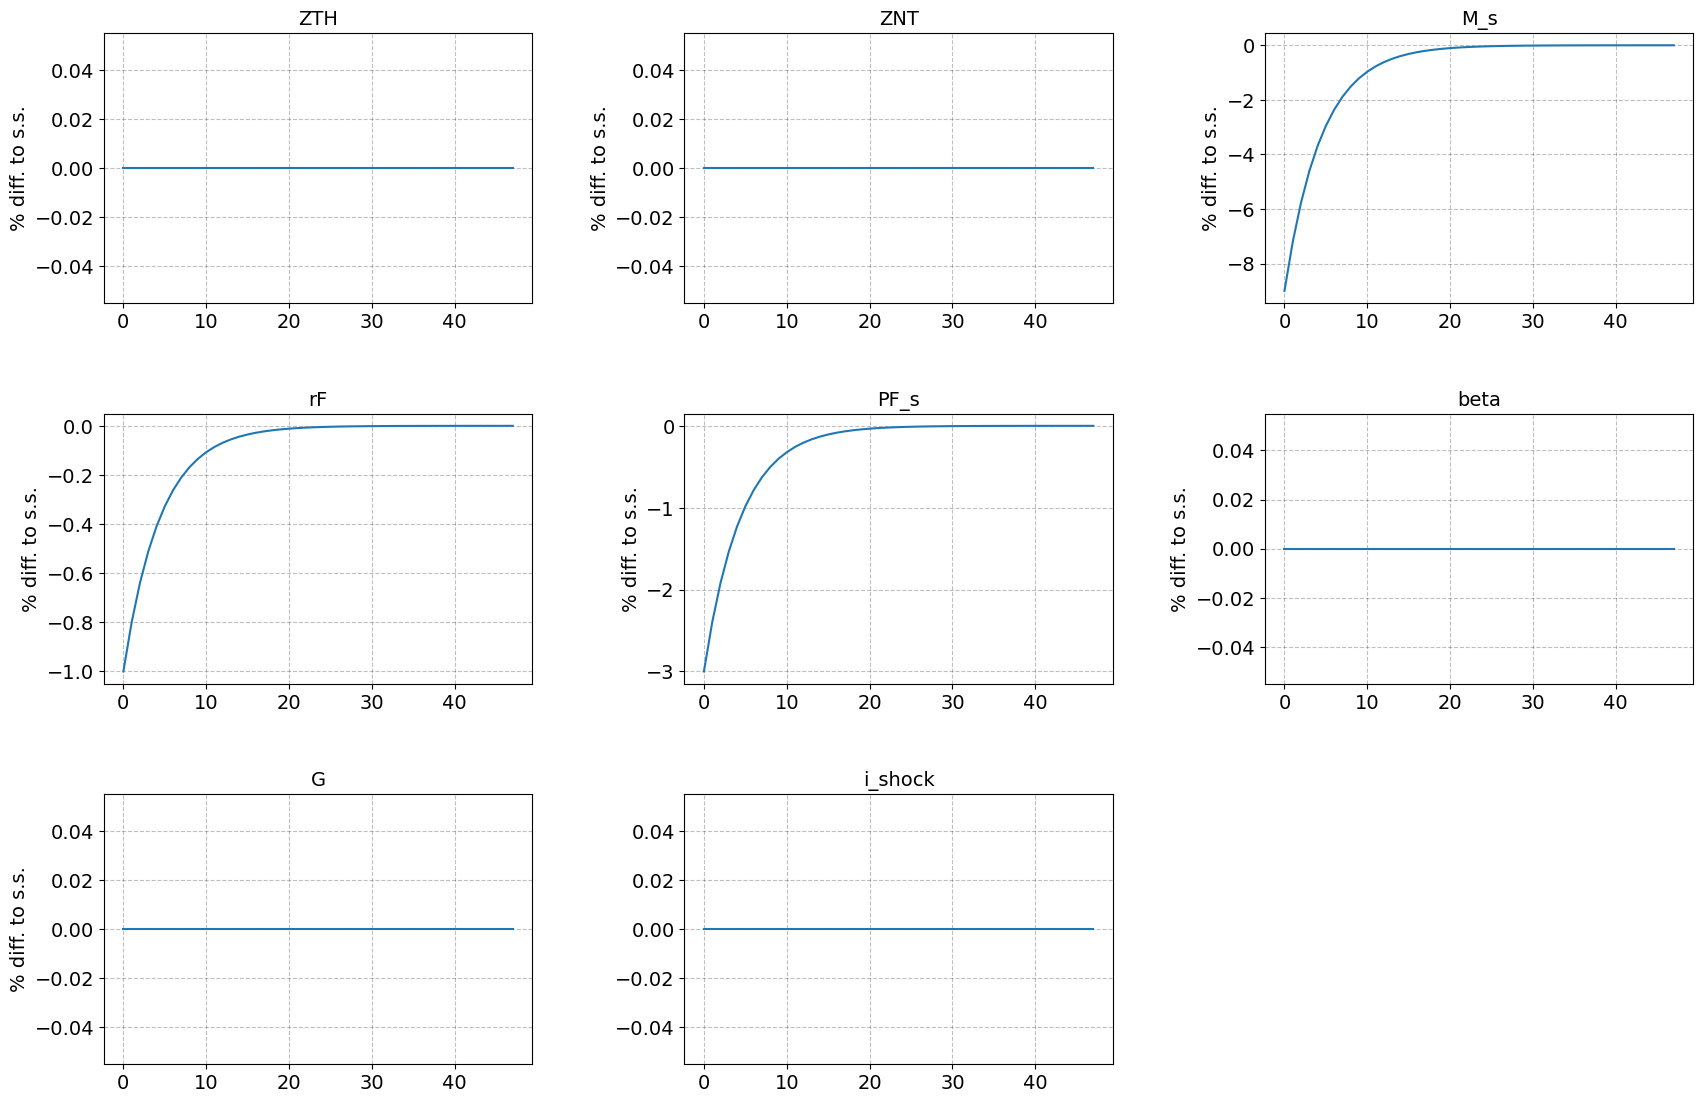


### varnames ###


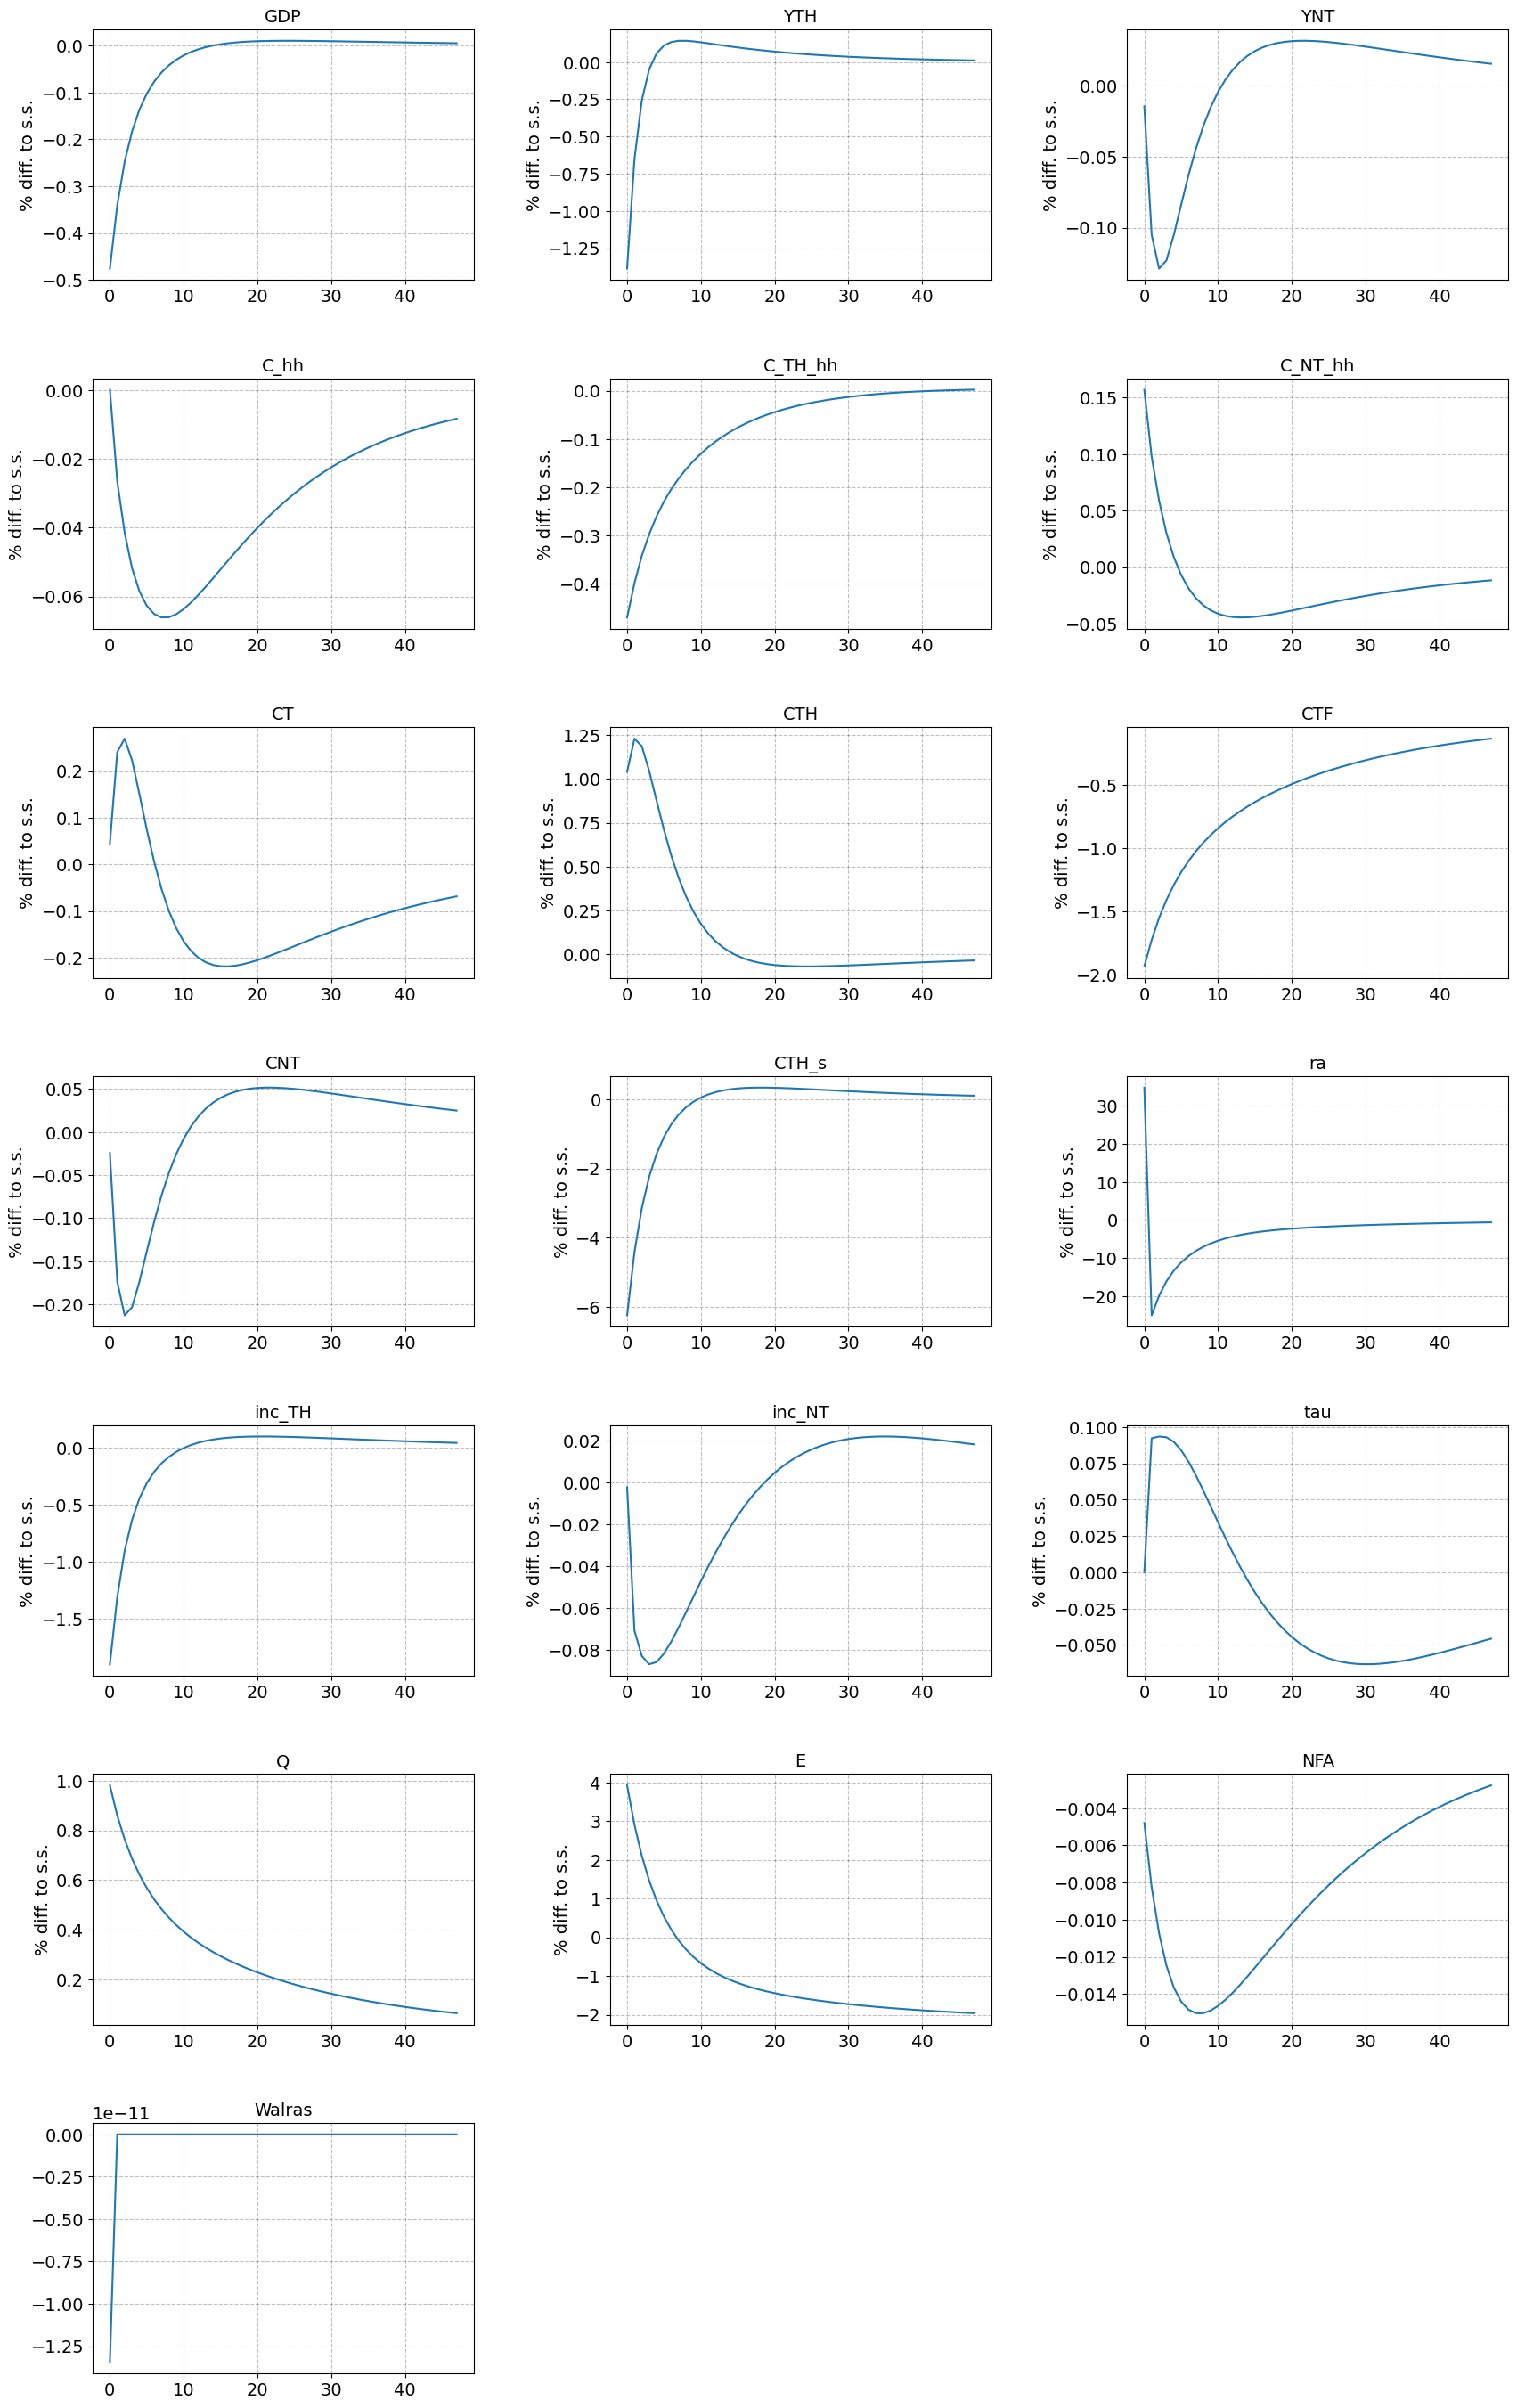


### tagets ###


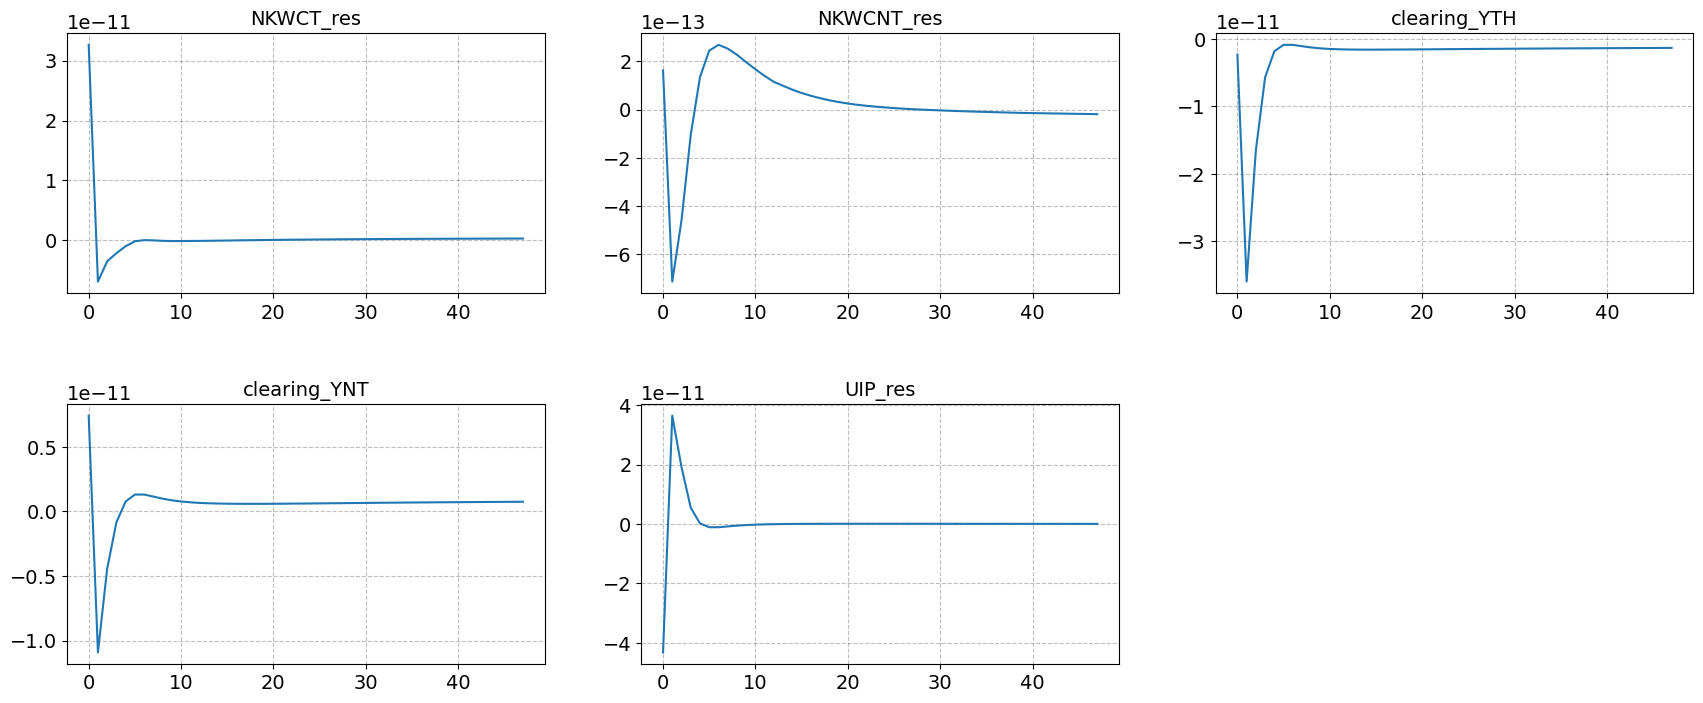

In [15]:
paths = ['GDP','YTH','YNT','C_hh','C_TH_hh','C_NT_hh','CT','CTH','CTF','CNT','CTH_s','ra','inc_TH','inc_NT','tau','Q','E','NFA','Walras']
lvl_value=['r','NFA','Walras','i_shock']
model.show_IRFs(paths,lvl_value=lvl_value,T_max=48,ncols=3)

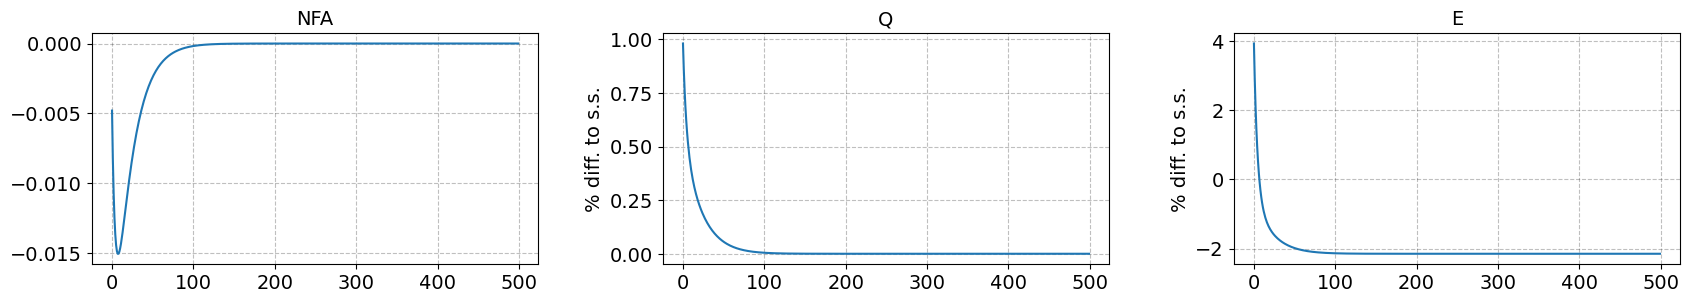

In [16]:
model.show_IRFs(['NFA','Q','E'],lvl_value=lvl_value,T_max=500,ncols=3,do_shocks=False,do_targets=False)

## 5. <a id='toc5_'></a>[Response in consumption to different shocks](#toc0_)

Foreign demand shock:

In [17]:
M_s = model.copy()
M_s.par.jump_M_s = -0.0075 # initial jump
M_s.par.rho_M_s = 0.80 # AR(1) coefficeint

M_s.par.jump_rF = -0.00005 # initial jump
M_s.par.rho_rF = 0.80 # AR(1) coefficeint

M_s.par.jump_PF_s = -0.03 # initial jump
M_s.par.rho_PF_s = 0.80 # AR(1) coefficeint

M_s.find_transition_path(shocks=['M_s','rF','PF_s'],do_print=False,do_end_check=False)

Domestic Beta shock:

In [18]:
beta = model.copy()
beta.par.jump_beta = 0.01 # initial jump
beta.par.rho_beta = 0.80 # AR(1) coefficeint

beta.find_transition_path(shocks=['beta'],do_print=False,do_end_check=False)

Domestic G shock:

In [19]:
G = model.copy()
G.par.jump_G = -0.025 # initial jump
G.par.rho_G = 0.80 # AR(1) coefficeint

G.find_transition_path(shocks=['G'],do_print=False,do_end_check=False)

Domestic i shock:

In [20]:
i_shock = model.copy()
i_shock.par.jump_i_shock = 0.01 # initial jump
i_shock.par.rho_i_shock = 0.80 # AR(1) coefficeint

i_shock.find_transition_path(shocks=['i_shock'],do_print=False,do_end_check=False)

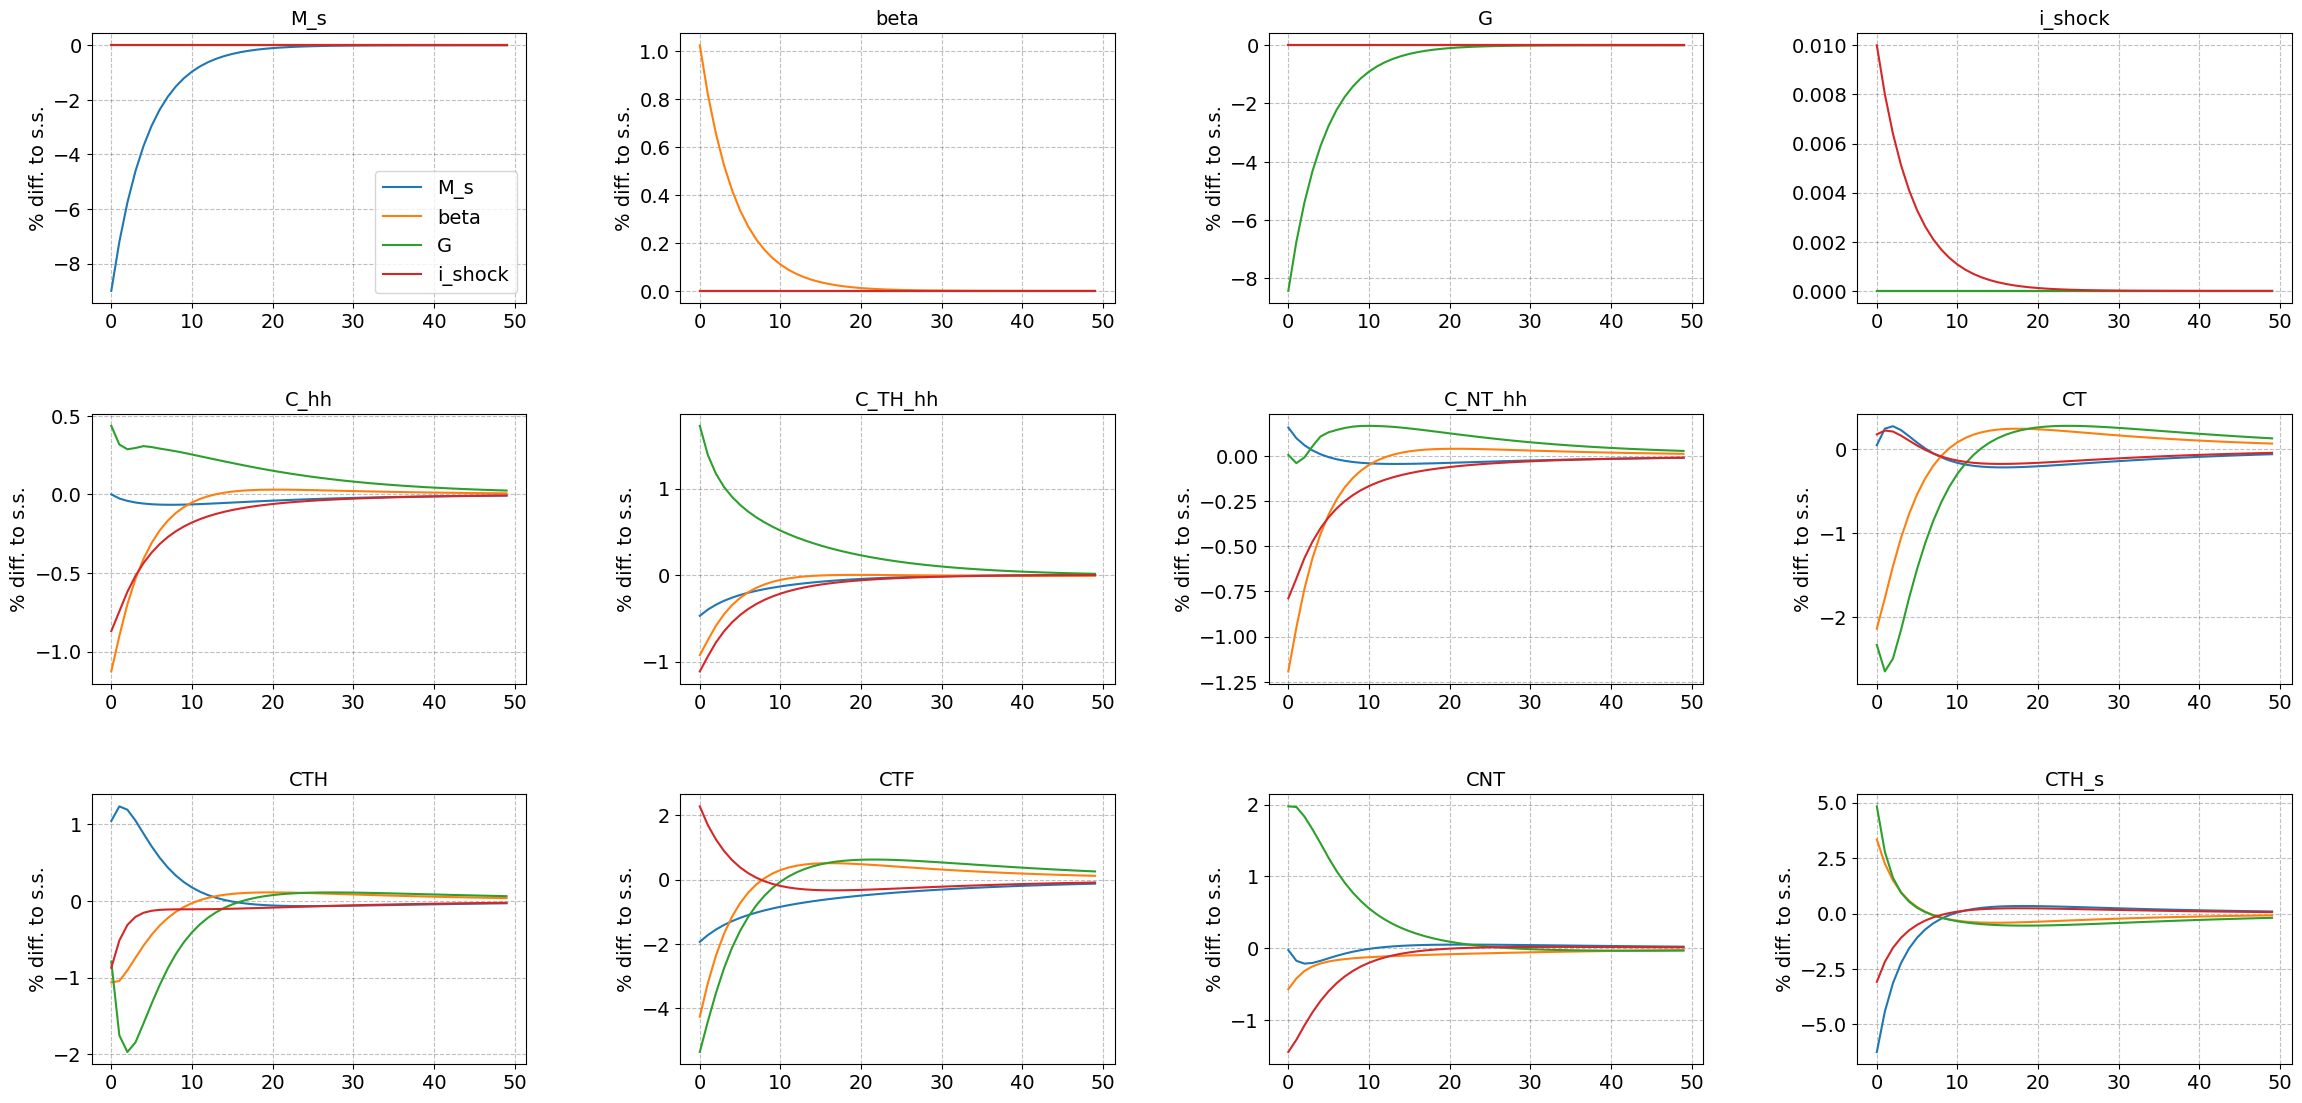

In [21]:
models = [M_s,beta,G,i_shock]
labels = ['M_s','beta','G','i_shock']
model.compare_IRFs(models,labels,varnames=['M_s','beta','G','i_shock','C_hh','C_TH_hh','C_NT_hh','CT','CTH','CTF','CNT','CTH_s'], do_shocks=False,do_targets=False,
        abs_diff=None,lvl_value=['i_shock'],T_max=50)

## 6. <a id='toc6_'></a>[Decomposing consumption response](#toc0_)

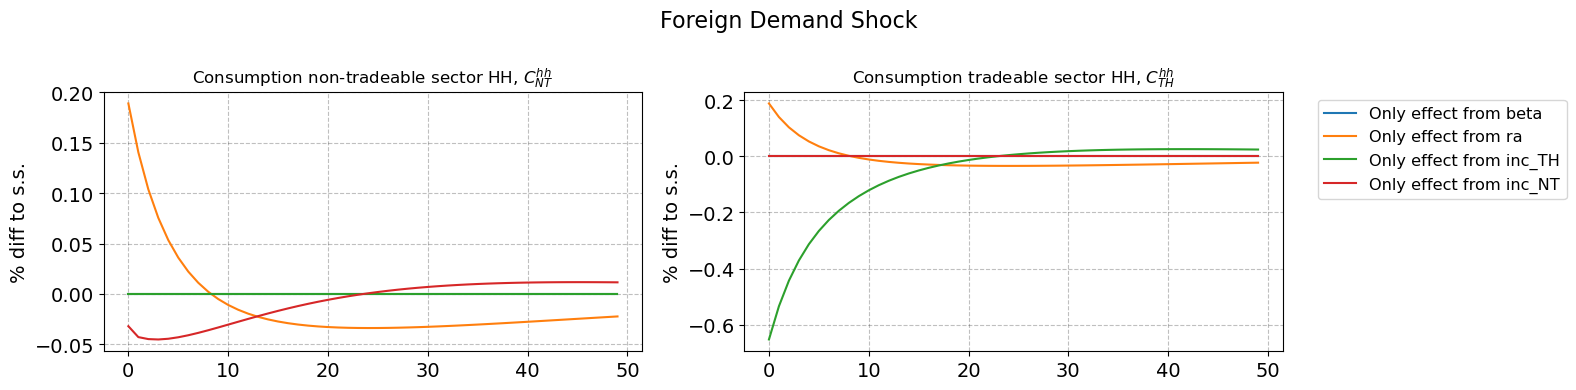

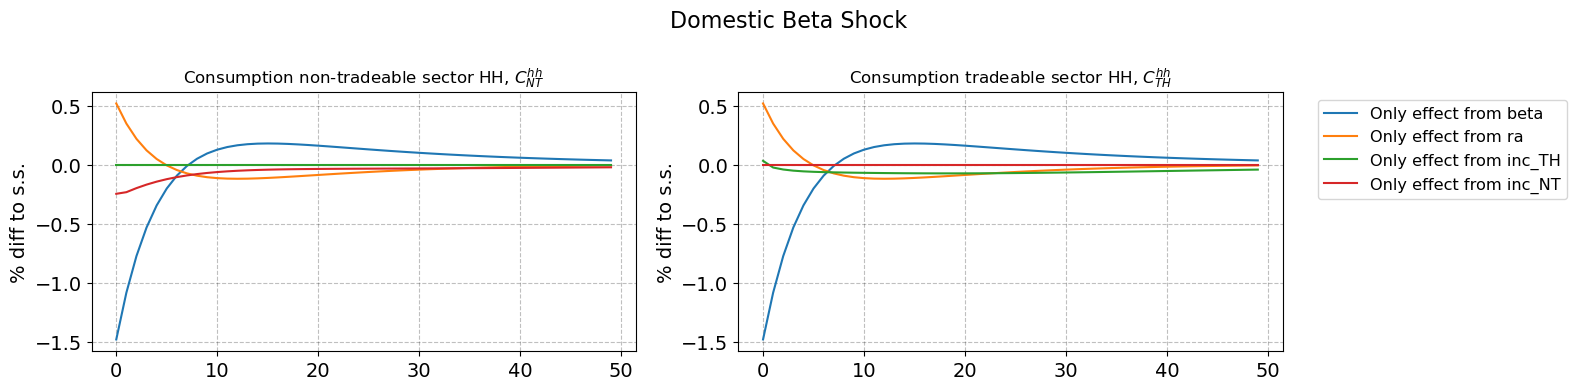

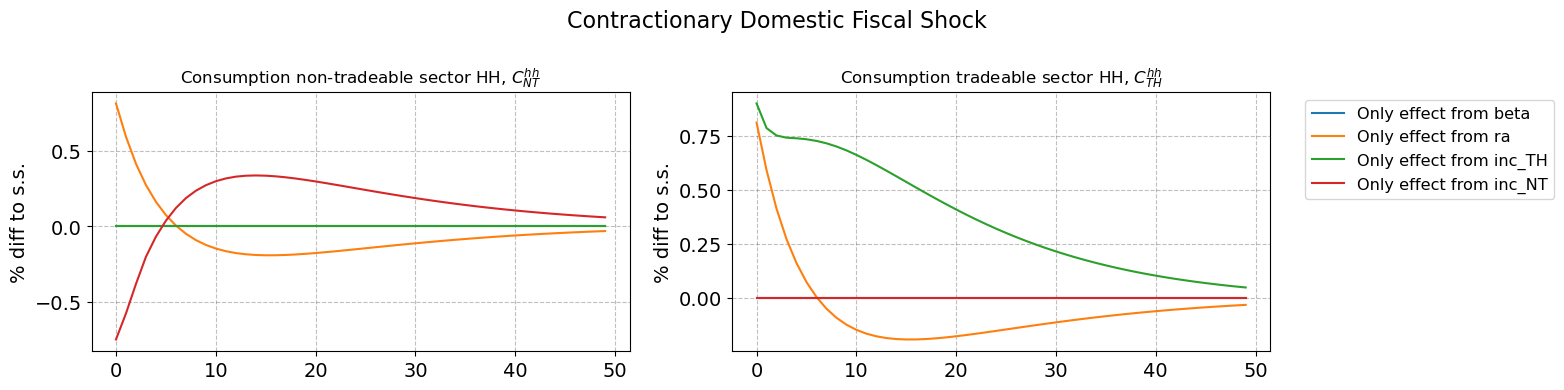

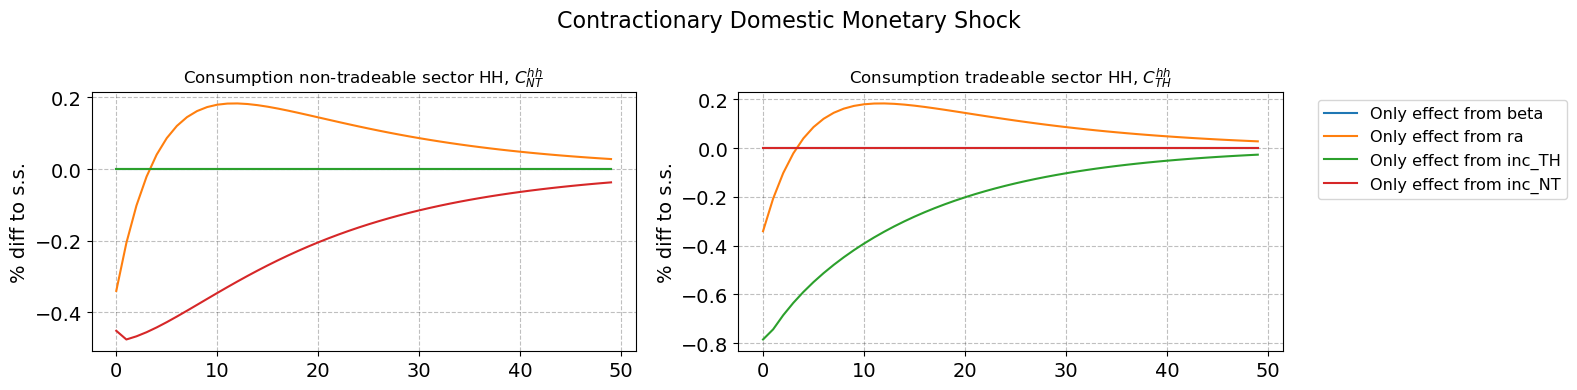

In [22]:
models = {'M_s': M_s, 'beta': beta, 'G': G, 'i_shock': i_shock}

model_titles = {
    'M_s': 'Foreign Demand Shock',
    'beta': 'Domestic Beta Shock',
    'G': 'Contractionary Domestic Fiscal Shock',
    'i_shock': 'Contractionary Domestic Monetary Shock'
}

for model_name, model in models.items():

    T_max = 50

    fig, (ax_C_NT, ax_C_TH) = plt.subplots(1, 2, figsize=(16, 4), dpi=100)
    fig.suptitle(f'{model_titles[model_name]}', fontsize=16)

    ax_C_NT.set_title('Consumption non-tradeable sector HH, $C_{NT}^{hh}$', fontsize=12)
    ax_C_TH.set_title('Consumption tradeable sector HH, $C_{TH}^{hh}$', fontsize=12)

    i_color = 0

    for use_inputs in [[x] for x in model.inputs_hh]:

        # a. compute
        path_alt = model.decompose_hh_path(do_print=False, use_inputs=use_inputs)

        # b. plot
        if use_inputs is None:
            label = 'No inputs'
            ls = '--'
            color = 'black'
        elif use_inputs == 'all':
            label = 'All inputs'
            ls = '-'
            color = 'black'
        else:
            label = f'Only effect from {use_inputs[0]}'
            ls = '-'
            color = f'C{i_color}' # use color index directly
            i_color += 1

        ax_C_NT.plot((path_alt.C_NT_hh[:T_max] / ss.C_NT_hh - 1) * 100, ls=ls, color=color, label=label)
        ax_C_TH.plot((path_alt.C_TH_hh[:T_max] / ss.C_TH_hh - 1) * 100, ls=ls, color=color, label=label)

    for ax in [ax_C_NT, ax_C_TH]:
        ax.set_ylabel('% diff to s.s.')
        lgd = ax_C_TH.legend(frameon=True, ncol=1, bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small')

    plt.tight_layout()  # Adjust layout to prevent overlapping
    plt.show()


## 7. <a id='toc7_'></a>[Fixed vs floating exchange rate](#toc0_)

In [23]:
fixed = model.copy()
fixed.par.float = False
fixed.find_ss()
fixed.compute_jacs()

Foreign demand shock:

In [24]:
M_s_fixed = fixed.copy()
M_s_fixed.par.jump_M_s = -0.0075 # initial jump
M_s_fixed.par.rho_M_s = 0.80 # AR(1) coefficeint

M_s_fixed.par.jump_rF = -0.00005 # initial jump
M_s_fixed.par.rho_rF = 0.80 # AR(1) coefficeint

M_s_fixed.par.jump_PF_s = -0.03 # initial jump
M_s_fixed.par.rho_PF_s = 0.80 # AR(1) coefficeint

M_s_fixed.find_transition_path(shocks=['M_s','rF','PF_s'])

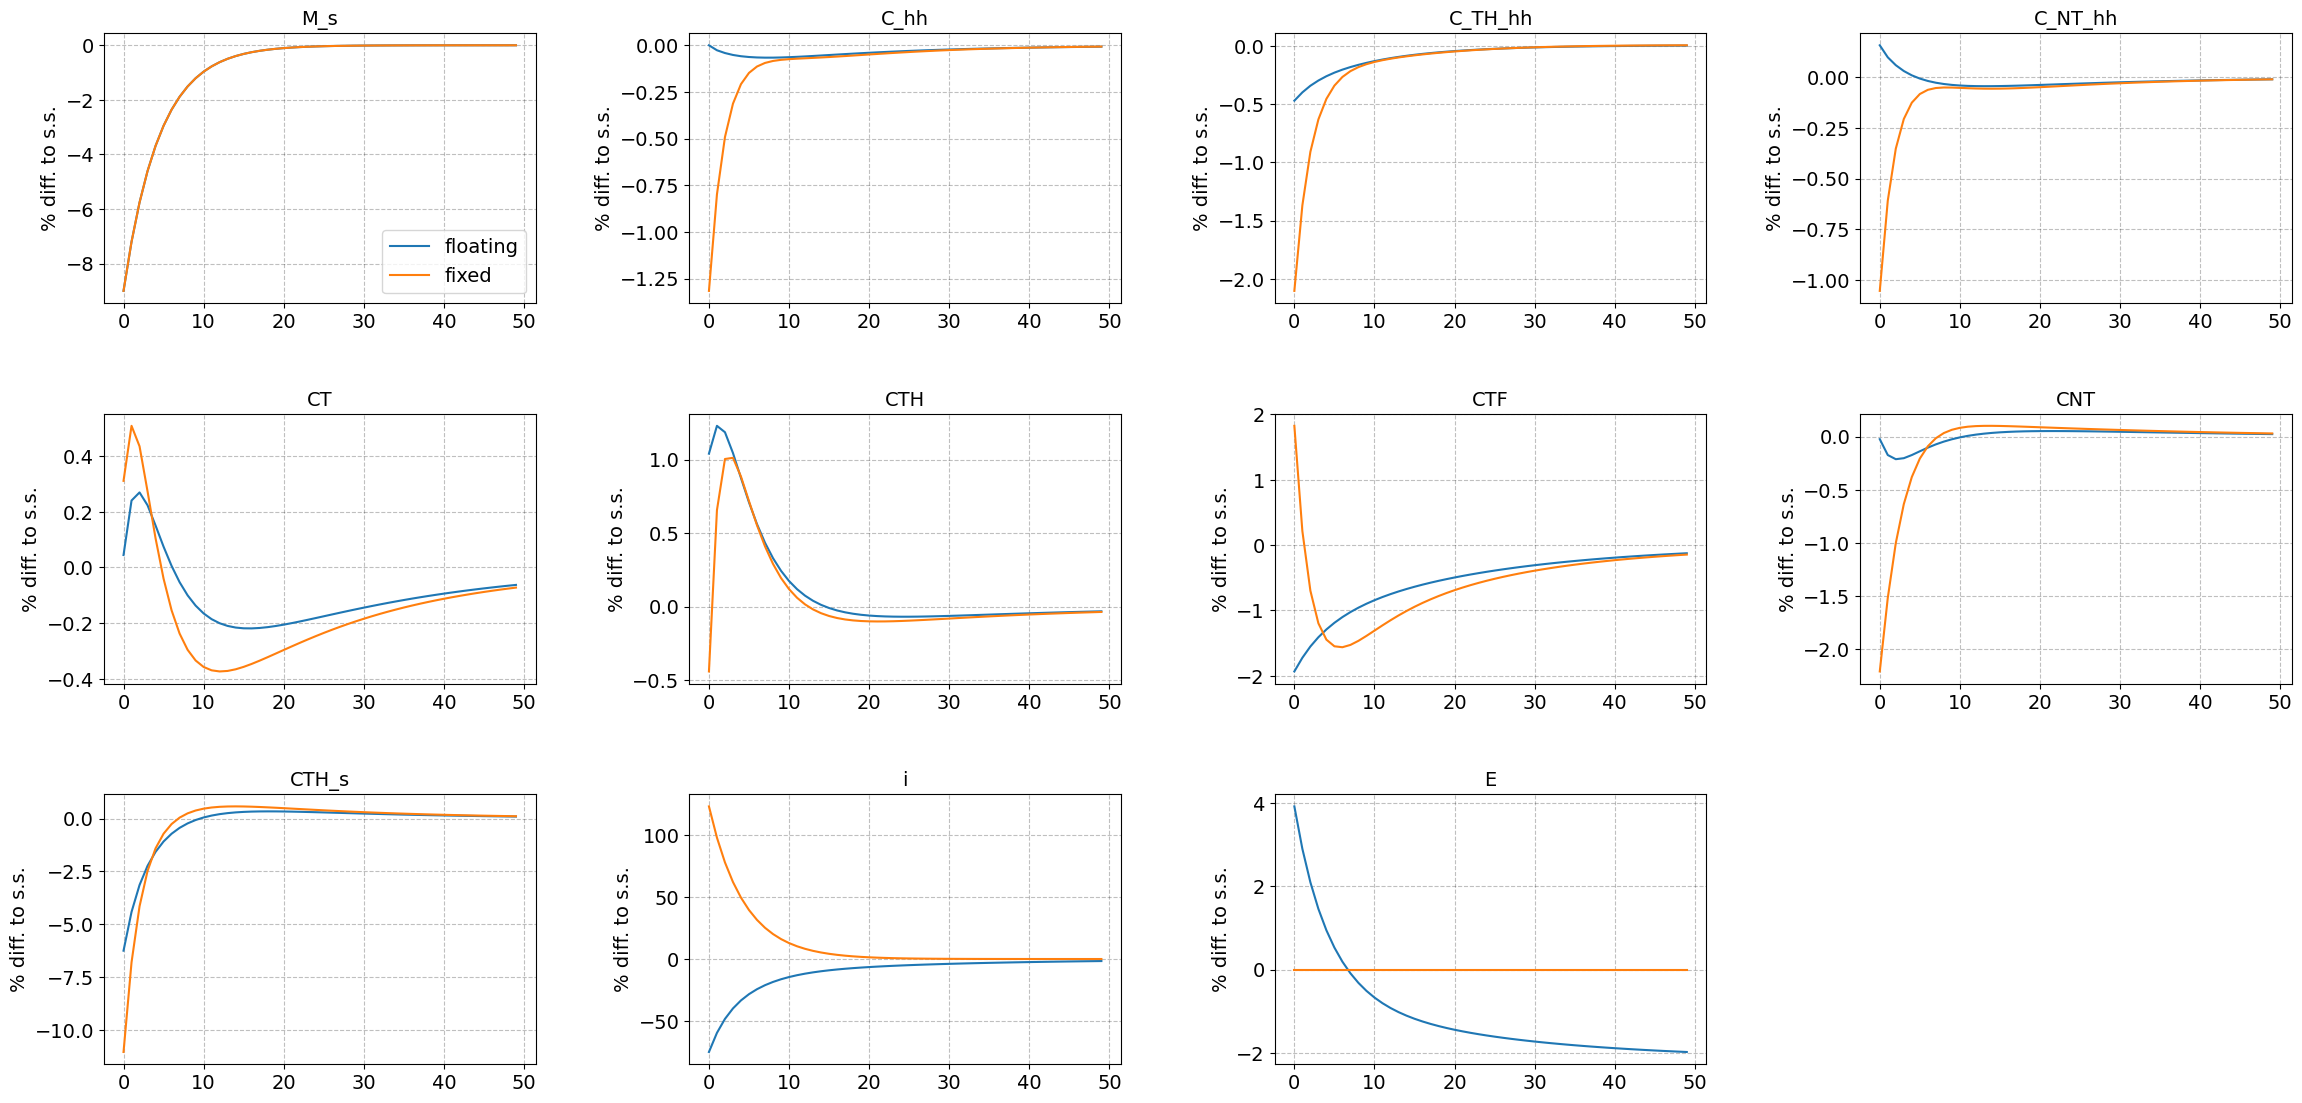

In [25]:
models = [M_s,M_s_fixed]
labels = ['floating','fixed']
model.compare_IRFs(models,labels,varnames=['M_s','C_hh','C_TH_hh','C_NT_hh','CT','CTH','CTF','CNT','CTH_s','i','E'], do_shocks=False,do_targets=False,
        abs_diff=None,lvl_value=['i_shock','pi'],T_max=50)

Domestic beta shock:

In [26]:
beta_fixed = fixed.copy()
beta_fixed.par.jump_beta = 0.01 # initial jump
beta_fixed.par.rho_beta = 0.80 # AR(1) coefficeint

beta_fixed.find_transition_path(shocks=['beta'])

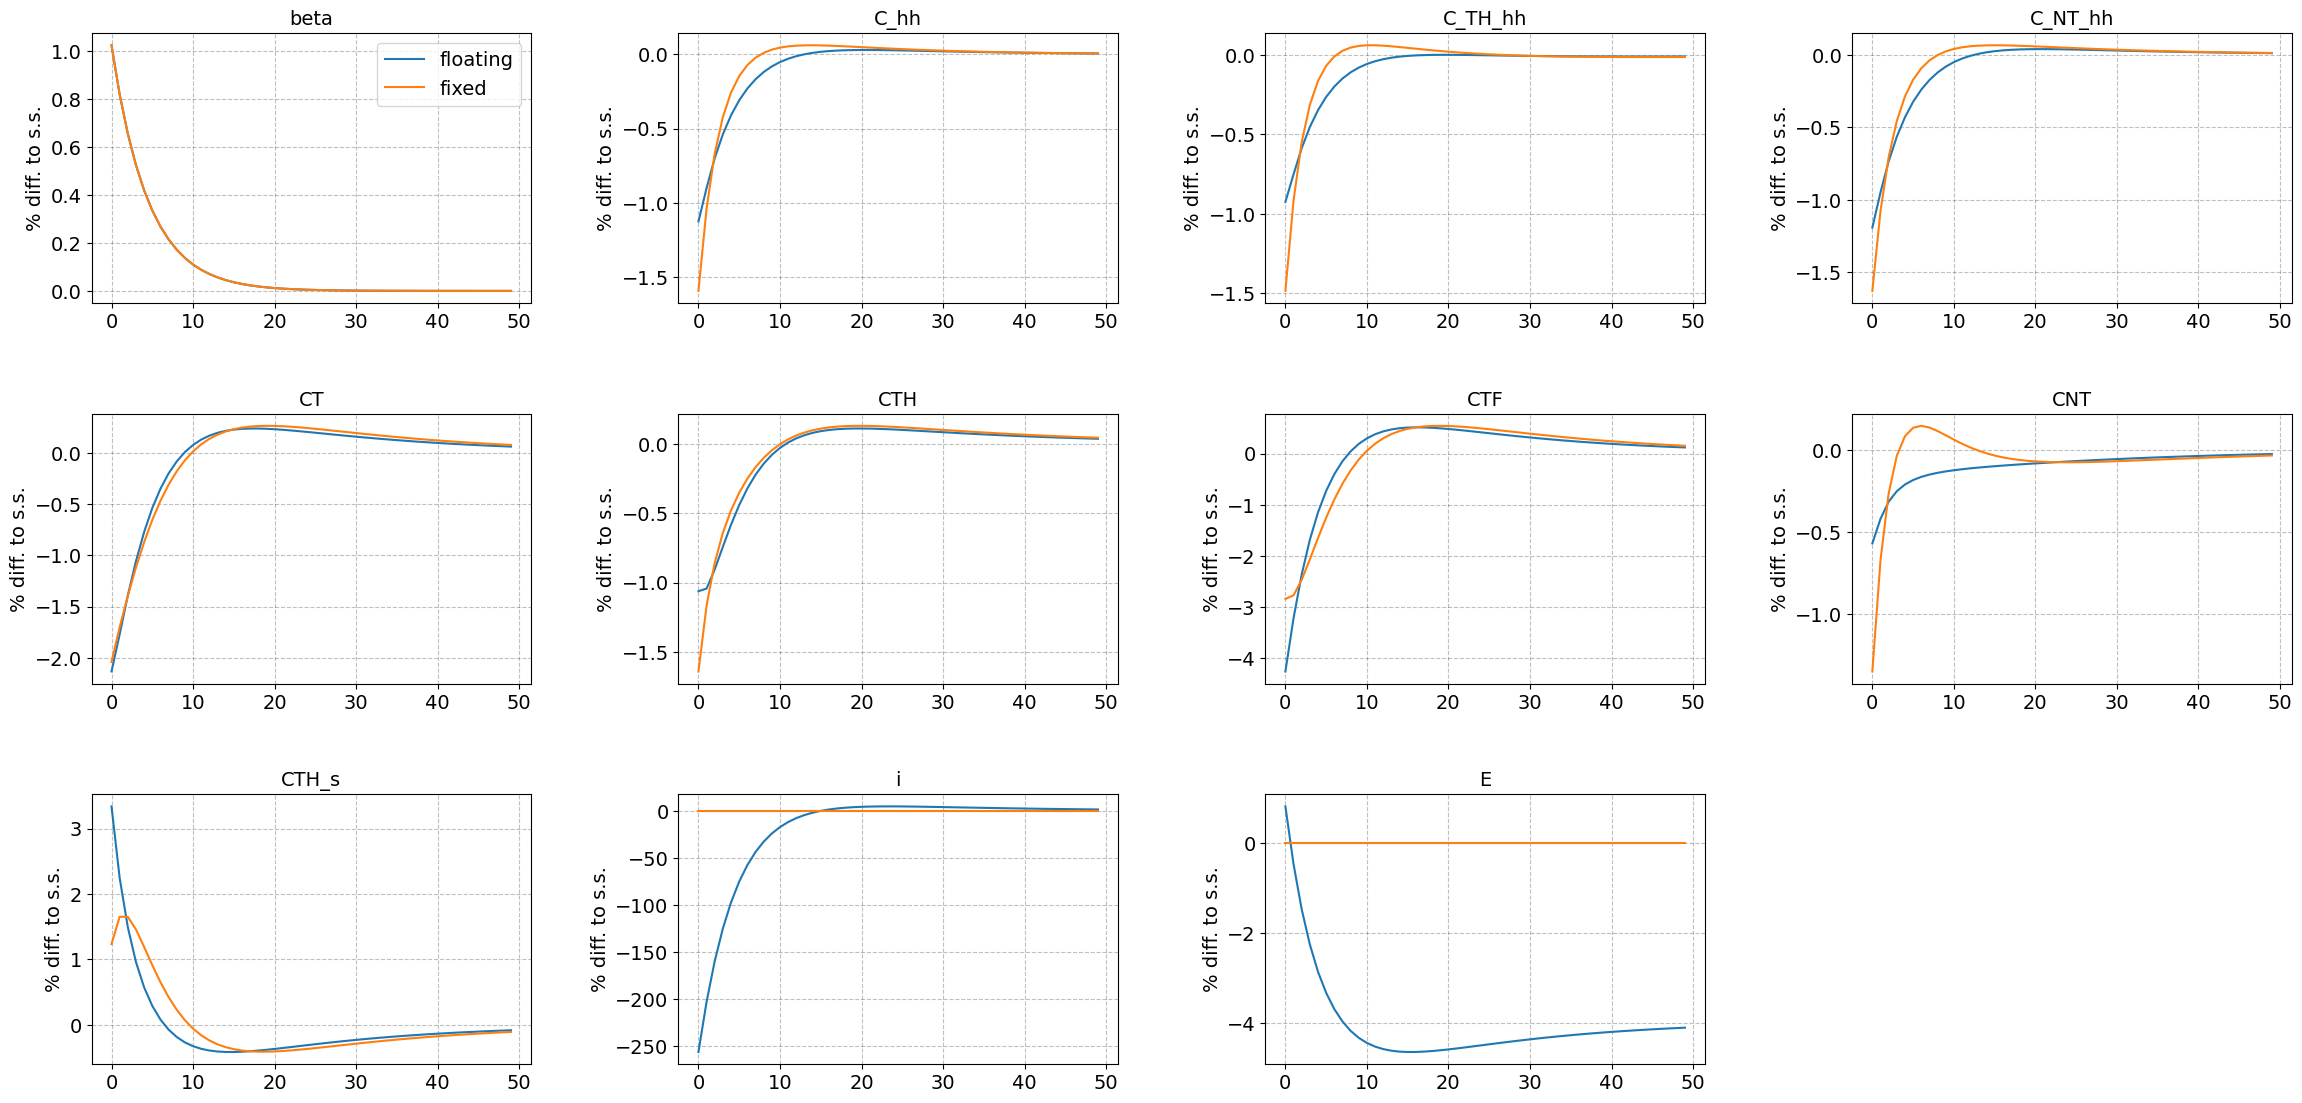

In [27]:
models = [beta,beta_fixed]
labels = ['floating','fixed']
model.compare_IRFs(models,labels,varnames=['beta','C_hh','C_TH_hh','C_NT_hh','CT','CTH','CTF','CNT','CTH_s','i','E'], do_shocks=False,do_targets=False,
        abs_diff=None,lvl_value=['i_shock'],T_max=50)

Domestic G shock:

In [28]:
G_fixed = fixed.copy()
G_fixed.par.jump_G = -0.025 # initial jump
G_fixed.par.rho_G = 0.80 # AR(1) coefficeint

G_fixed.find_transition_path(shocks=['G'])

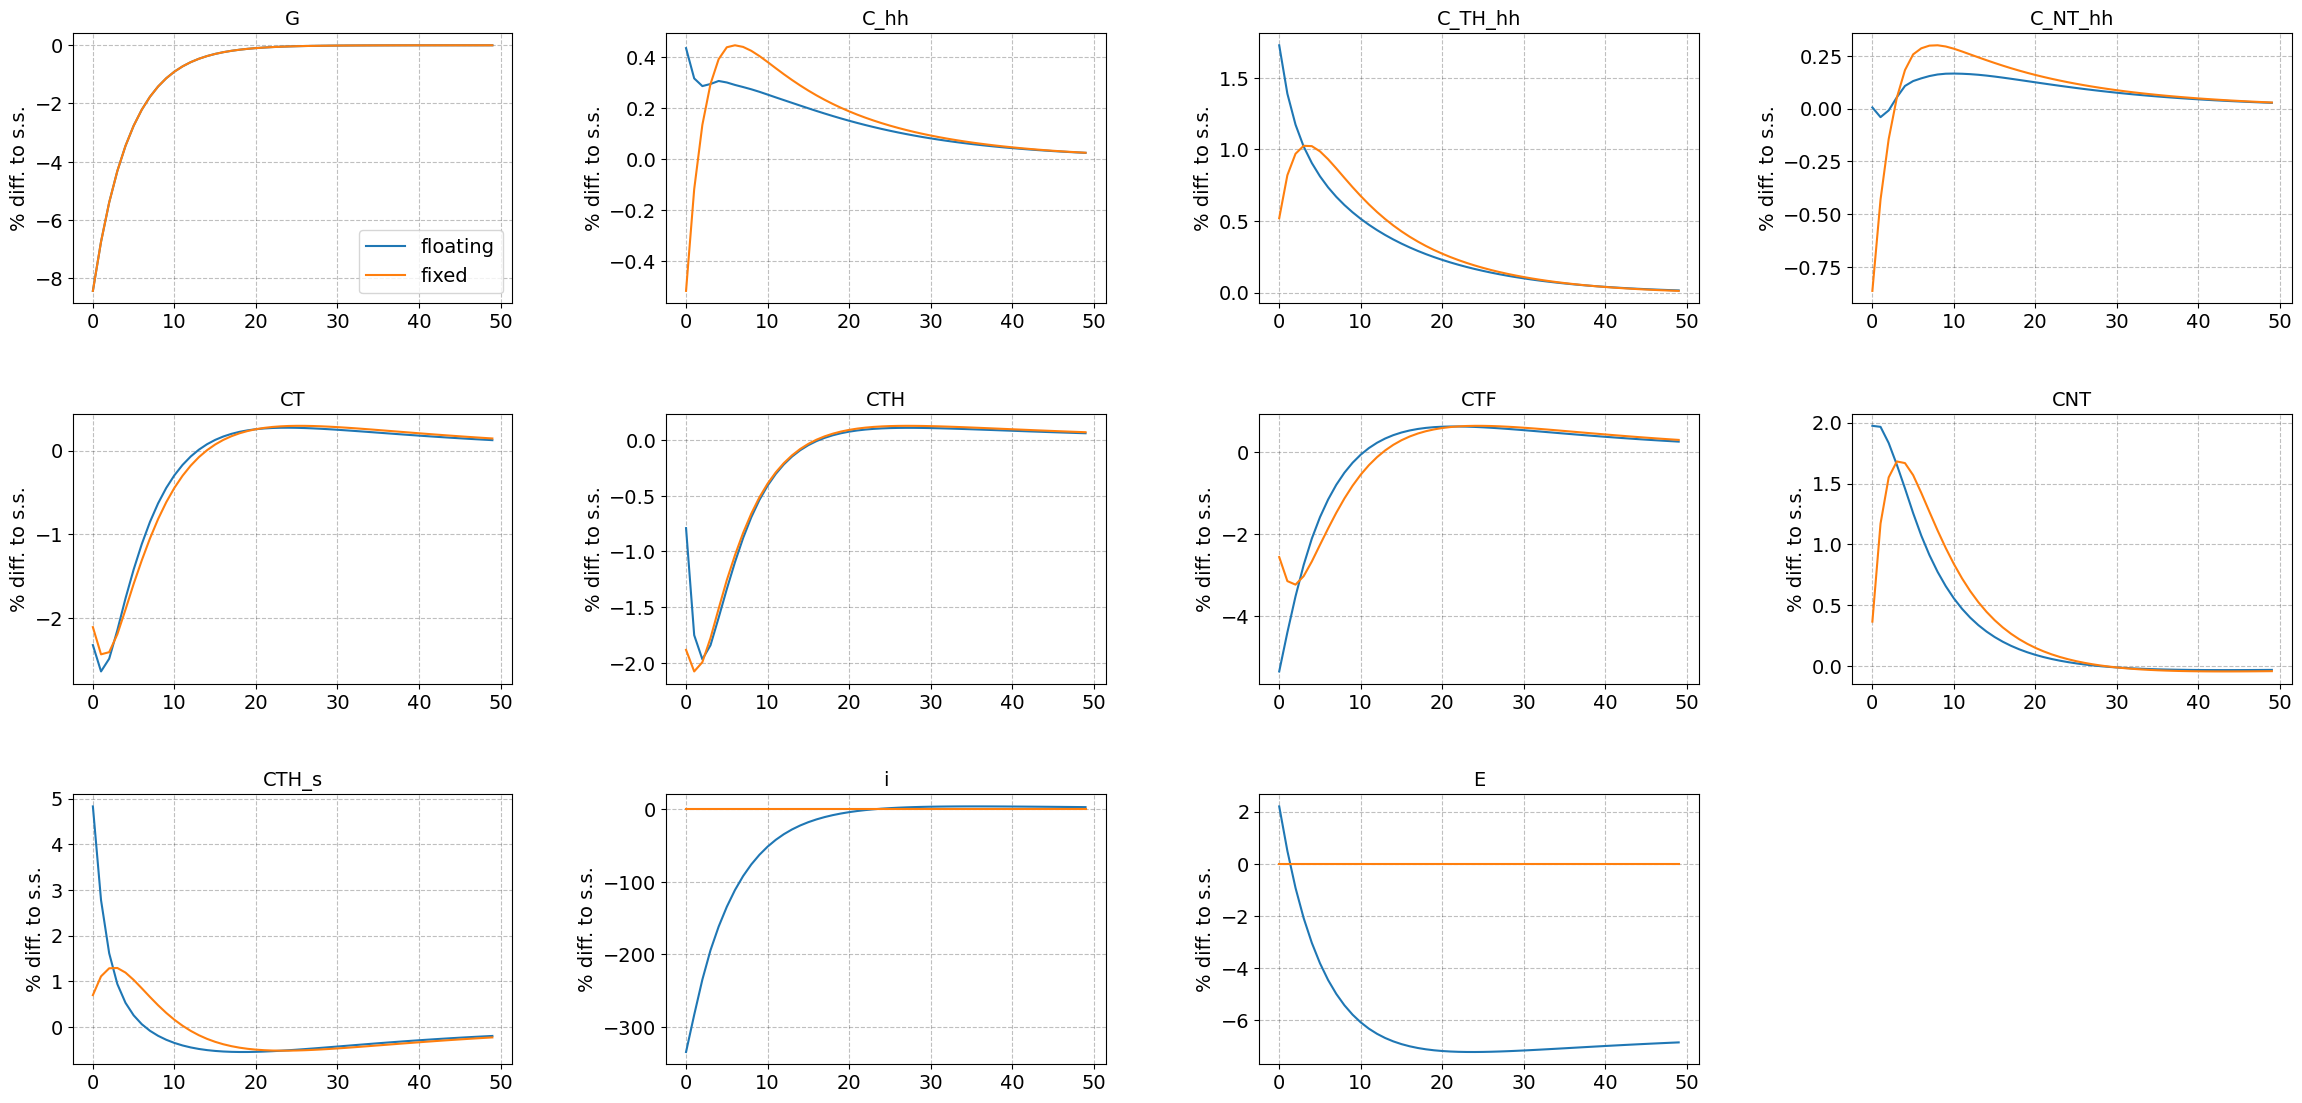

In [29]:
models = [G,G_fixed]
labels = ['floating','fixed']
model.compare_IRFs(models,labels,varnames=['G','C_hh','C_TH_hh','C_NT_hh','CT','CTH','CTF','CNT','CTH_s','i','E'], do_shocks=False,do_targets=False,
        abs_diff=None,lvl_value=['i_shock'],T_max=50)

## 8. <a id='toc8_'></a>[Decomposing consumption response under fixed exchange rate](#toc0_)

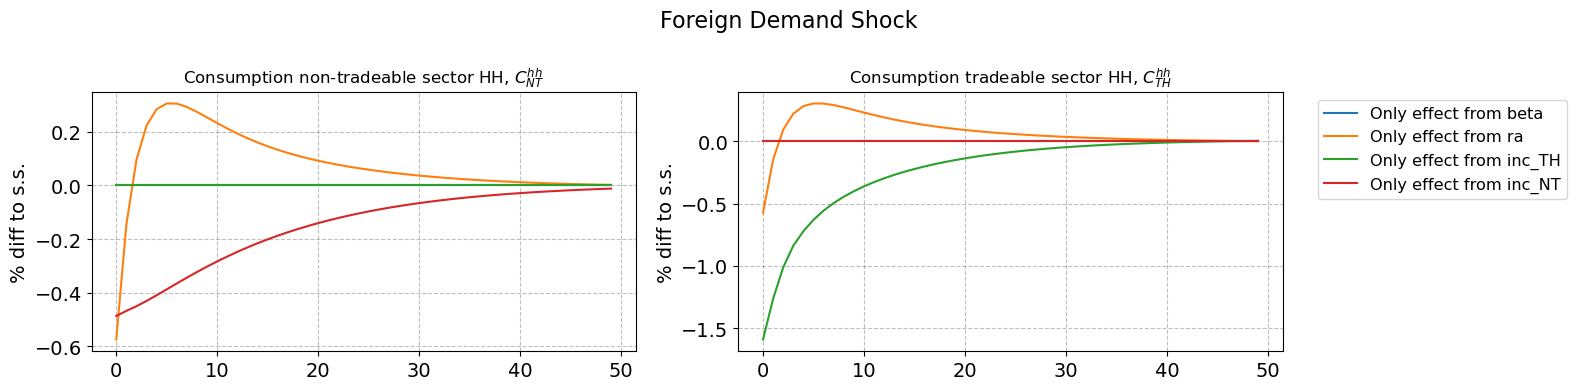

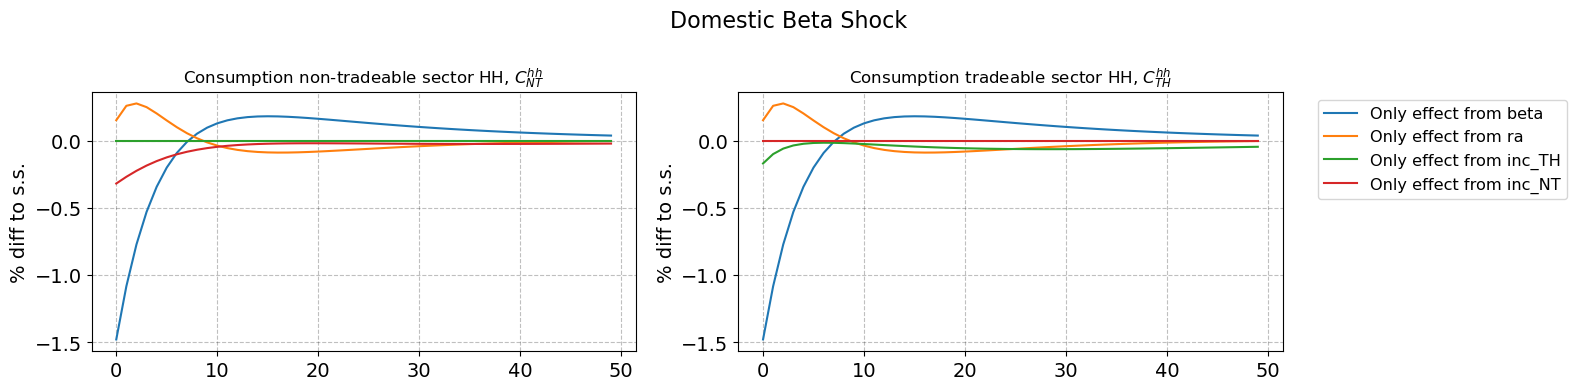

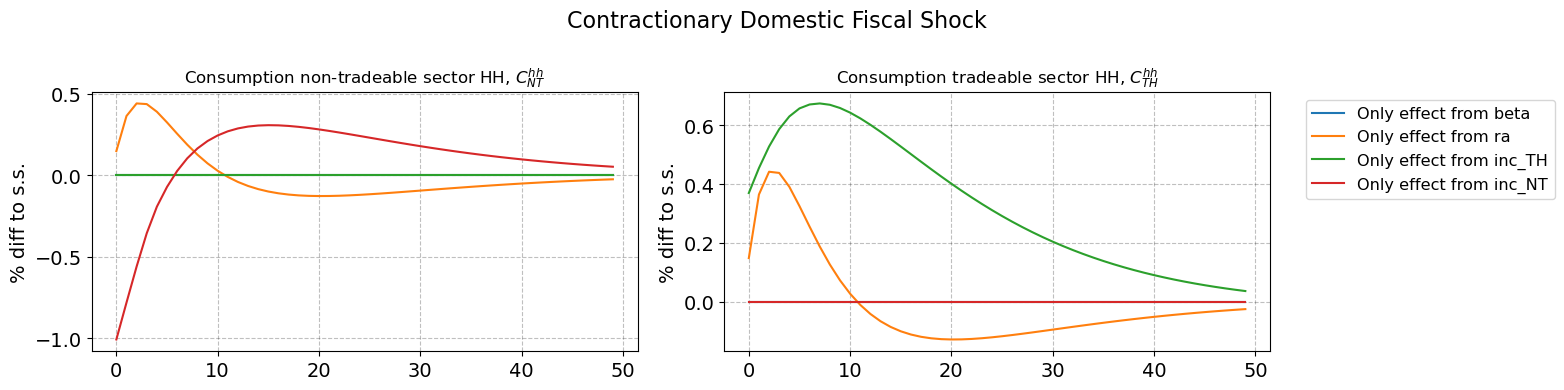

In [30]:
models = {'M_s': M_s_fixed, 'beta': beta_fixed, 'G': G_fixed}

model_titles = {
    'M_s': 'Foreign Demand Shock',
    'beta': 'Domestic Beta Shock',
    'G': 'Contractionary Domestic Fiscal Shock'   
}

for model_name, model in models.items():

    T_max = 50

    fig, (ax_C_NT, ax_C_TH) = plt.subplots(1, 2, figsize=(16, 4), dpi=100)
    fig.suptitle(f'{model_titles[model_name]}', fontsize=16)

    ax_C_NT.set_title('Consumption non-tradeable sector HH, $C_{NT}^{hh}$', fontsize=12)
    ax_C_TH.set_title('Consumption tradeable sector HH, $C_{TH}^{hh}$', fontsize=12)

    i_color = 0

    for use_inputs in [[x] for x in model.inputs_hh]:

        # a. compute
        path_alt = model.decompose_hh_path(do_print=False, use_inputs=use_inputs)

        # b. plot
        if use_inputs is None:
            label = 'No inputs'
            ls = '--'
            color = 'black'
        elif use_inputs == 'all':
            label = 'All inputs'
            ls = '-'
            color = 'black'
        else:
            label = f'Only effect from {use_inputs[0]}'
            ls = '-'
            color = f'C{i_color}' # use color index directly
            i_color += 1

        ax_C_NT.plot((path_alt.C_NT_hh[:T_max] / ss.C_NT_hh - 1) * 100, ls=ls, color=color, label=label)
        ax_C_TH.plot((path_alt.C_TH_hh[:T_max] / ss.C_TH_hh - 1) * 100, ls=ls, color=color, label=label)

    for ax in [ax_C_NT, ax_C_TH]:
        ax.set_ylabel('% diff to s.s.')
        lgd = ax_C_TH.legend(frameon=True, ncol=1, bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small')

    plt.tight_layout()  # Adjust layout to prevent overlapping
    plt.show()
